In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from datetime import timedelta

In [115]:
features = pd.read_csv("all_features.csv")

In [116]:
features = features.set_index("Date")

In [117]:
features.columns

Index(['n_posts', 'total_score', 'avg_score', 'total_comments', 'avg_comments',
       'avg_upvote_ratio', 'std_upvote_ratio', 'weighted_sentiment', 'AEVA',
       'ATRO', 'DRD', 'GRPN', 'NGVC', 'RDFN', 'ROOT', 'TDUP', 'technology',
       'industrials', 'materials', 'communication_services',
       'consumer_defensive', 'real_estate', 'financial_services',
       'consumer_cyclical', 'AEVA_sentiment', 'ATRO_sentiment',
       'DRD_sentiment', 'GRPN_sentiment', 'NGVC_sentiment', 'RDFN_sentiment',
       'ROOT_sentiment', 'TDUP_sentiment', 'technology_sentiment',
       'industrials_sentiment', 'materials_sentiment',
       'communication_services_sentiment', 'consumer_defensive_sentiment',
       'real_estate_sentiment', 'financial_services_sentiment',
       'consumer_cyclical_sentiment', 'sentiment_label'],
      dtype='object')

In [118]:
colums = ["n_posts", "total_score", "avg_score", "total_comments", "avg_comments", 'avg_upvote_ratio', "std_upvote_ratio"]

In [119]:
post_mega = features[colums]

In [120]:
post_mega

,n_posts,total_score,avg_score,total_comments,avg_comments,avg_upvote_ratio,std_upvote_ratio
Date,,,,,,,
2022-01-01,45,6826.0,151.688889,5276.0,117.244444,0.784000,0.142181
2022-01-02,62,20694.0,333.774194,7896.0,127.354839,0.726452,0.201642
2022-01-03,80,8157.0,101.962500,4635.0,57.937500,0.748875,0.183772
2022-01-04,107,6301.0,58.887850,6044.0,56.485981,0.754019,0.187706
2022-01-05,103,6813.0,66.145631,6585.0,63.932039,0.772233,0.196284
...,...,...,...,...,...,...,...
2024-12-27,185,2436.0,13.167568,3718.0,20.097297,0.755730,0.248061
2024-12-28,117,1456.0,12.444444,2377.0,20.316239,0.724359,0.254217
2024-12-29,113,1377.0,12.185841,2177.0,19.265487,0.701504,0.247344


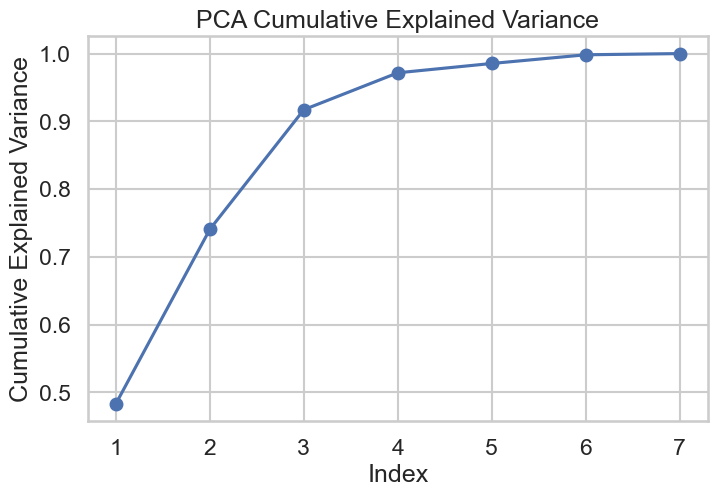

In [121]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(post_mega)

# Apply PCA
pca = PCA()
pca_result = pca.fit(scaled_data)

# Cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-')
plt.xlabel("Index")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Cumulative Explained Variance")
plt.grid(True)
plt.savefig("PCA.png")
plt.show()
## Choose 3 PCs

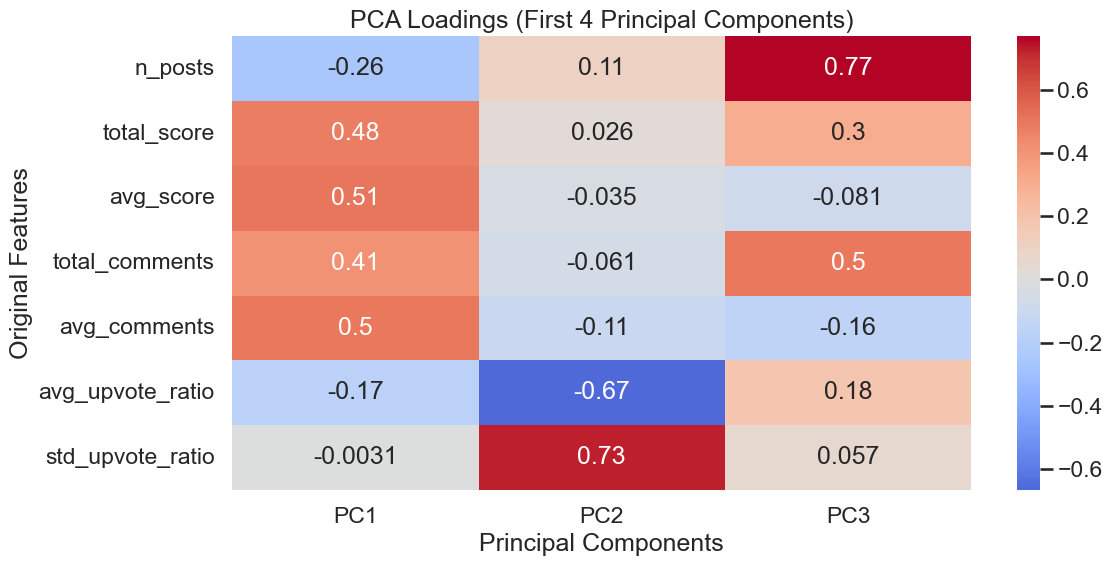

In [122]:
# Apply PCA on actual feature set
pca = PCA(n_components=3)
pca_result = pca.fit(scaled_data)

# Create DataFrame with actual number of features
loadings = pd.DataFrame(pca.components_.T,  
                        columns=['PC1', 'PC2', 'PC3'],
                        index=post_mega.columns)  

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings (First 4 Principal Components)')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.tight_layout()
plt.savefig("loading.png")
plt.show()


In [123]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3'])


pca_df.index = post_mega.index 
pca_df.reset_index(inplace = True)

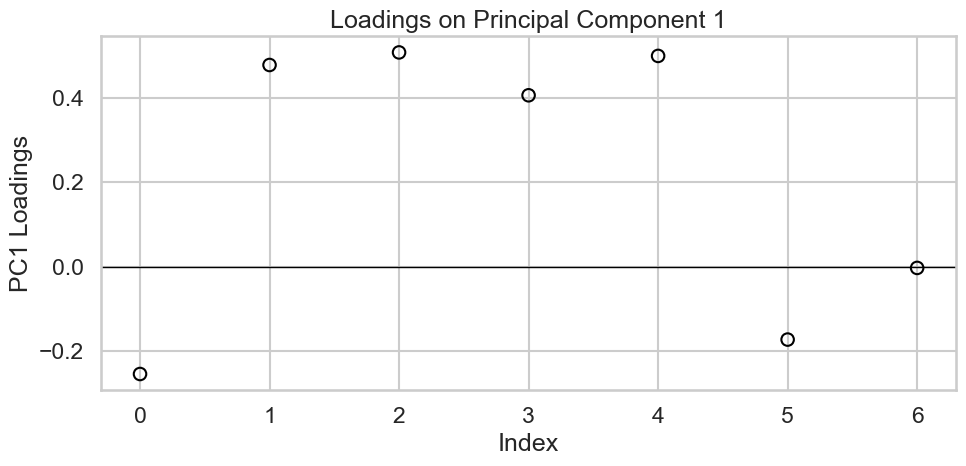

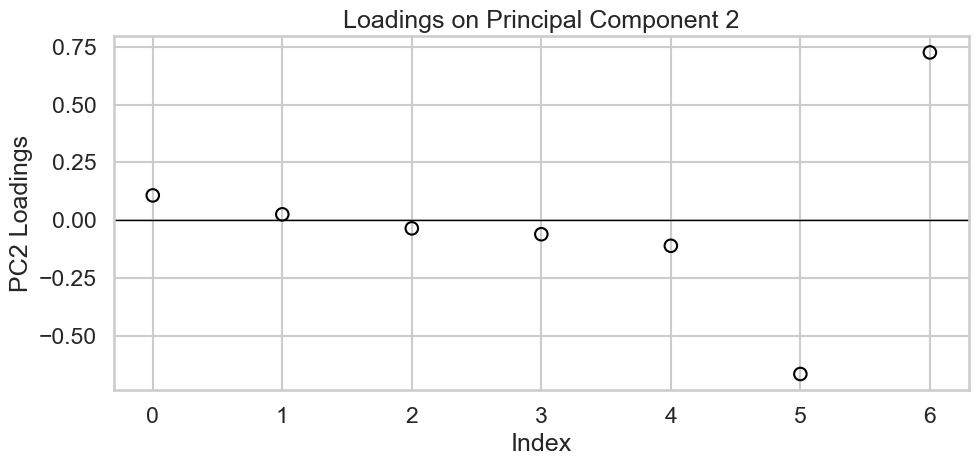

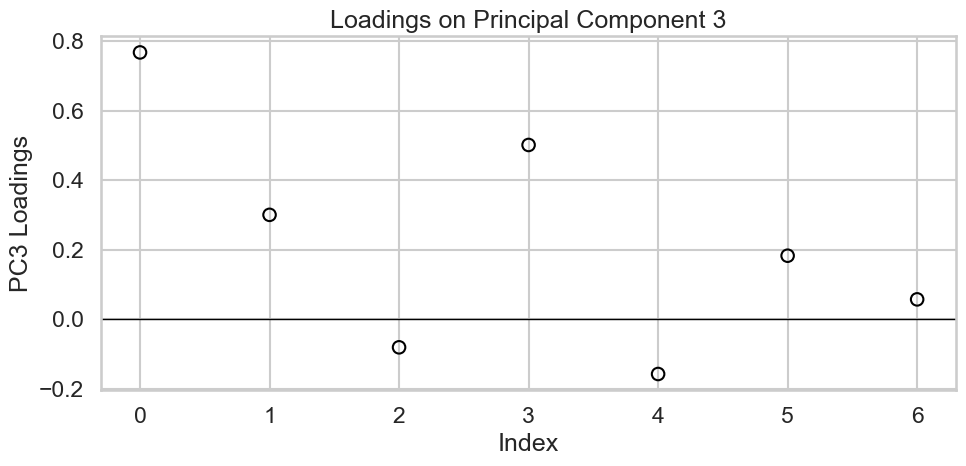

In [124]:
for i in range(3):  # PC1 to PC3
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(pca.components_[i])),
                pca.components_[i],
                edgecolors='black',
                facecolors='none')
    plt.axhline(y=0, color='black', linewidth=1)
    plt.xlabel('Index')
    plt.ylabel(f'PC{i+1} Loadings')
    plt.title(f'Loadings on Principal Component {i+1}')
    plt.tight_layout()
    plt.show()

In [125]:
stocks = pd.read_csv("stock_data.csv")

In [126]:
stocks= stocks.set_index(["Date", "Ticker"])

In [127]:
stocks = stocks.unstack()

In [128]:
close = stocks['Close']
volume = stocks['Volume']

# Compute log returns for each ticker
log_returns = np.log(close / close.shift(1))
log_returns.columns = [f'{col}_log_return' for col in log_returns.columns]

# Compute percentage change in volume
volume_pct_change = volume.pct_change()
volume_pct_change.columns = [f'{col}_vol_pct_change' for col in volume_pct_change.columns]

# Combine features
features = pd.concat([log_returns, volume_pct_change], axis=1)

/Users/sophialin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


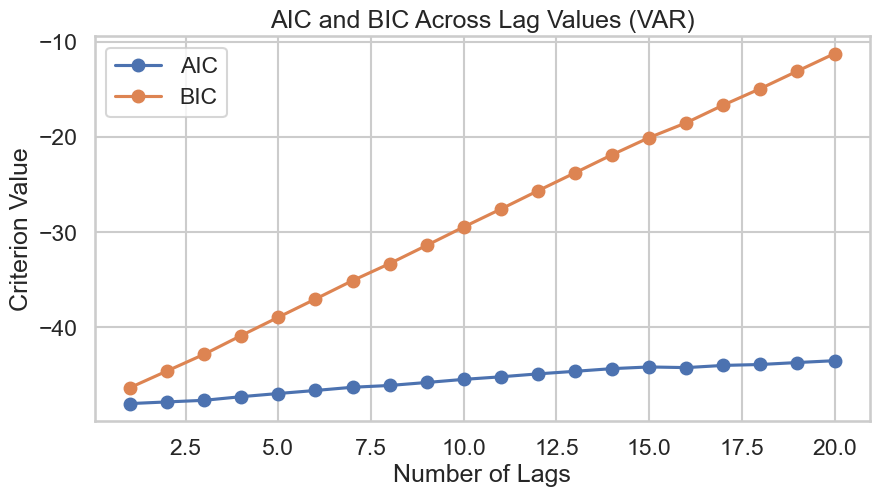

In [129]:
from statsmodels.tsa.api import VAR
base_features = features.dropna()
model = VAR(base_features)

# Store AIC and BIC manually for each lag
aic_values = []
bic_values = []
lags = range(1, 21)

for lag in lags:
    result = model.fit(lag)
    aic_values.append(result.aic)
    bic_values.append(result.bic)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(lags, aic_values, marker='o', label='AIC')
plt.plot(lags, bic_values, marker='o', label='BIC')
plt.xlabel("Number of Lags")
plt.ylabel("Criterion Value")
plt.title("AIC and BIC Across Lag Values (VAR)")
plt.savefig("AIC.png")
plt.legend()

In [130]:
stock = pd.read_csv("long_table_full.csv")

In [131]:
stock.drop(columns="Unnamed: 0", inplace = True)

In [132]:
stock = stock.sort_values(by=['Ticker', 'Date'])

stock['Return_Lag1'] = stock.groupby('Ticker')['Return'].shift(1)
stock['Volume_Lag1'] = stock.groupby('Ticker')['Volume'].shift(1)
stock = stock.sort_values(by=['Date','Ticker'])

In [133]:
macro = pd.read_csv("macro_merged.csv")

In [134]:
macro.DATE = pd.to_datetime(macro.DATE)
macro.rename(columns={"DATE":"Date"}, inplace = True)
macro.drop(columns= "Unnamed: 0", inplace = True)

In [135]:
stock.Date = pd.to_datetime(stock.Date)

In [136]:
full = pd.merge(stock, macro, on = "Date", how = "left")

In [137]:
pca_df.Date = pd.to_datetime(pca_df.Date)

In [138]:
full = pd.merge(full, pca_df, on = "Date", how = "left")

In [139]:
full['Return_Binary'] = (full['Return'] > 0).astype(int)

In [140]:
full.drop(columns = "Sector", inplace = True)

In [141]:
full

,Date,Ticker,Return,market_sentiment,sector_sentiment,7D_Rolling_Mean,7D_Rolling_Variance,Volume,ticker_freq,sector_freq,...,Volume_Lag1,Epi,CPI,FED_RATE,GDP,IPI,PC1,PC2,PC3,Return_Binary
0,2022-01-04,AEVA,-0.034641,0.238024,-0.049327,NaN,NaN,-0.236455,0.0,0.241935,...,NaN,2.93,3.966999,0.08,21903.850,101.2146,1.150988,-0.215267,1.524759,0
1,2022-01-04,ATRO,0.068327,0.238024,-0.563499,NaN,NaN,-0.596350,0.0,0.016129,...,NaN,2.93,3.966999,0.08,21903.850,101.2146,1.150988,-0.215267,1.524759,1
2,2022-01-04,DRD,-0.007335,0.238024,0.554175,NaN,NaN,0.652325,0.0,0.096774,...,NaN,2.93,3.966999,0.08,21903.850,101.2146,1.150988,-0.215267,1.524759,0
3,2022-01-04,GRPN,-0.015399,0.238024,0.909100,NaN,NaN,-0.682022,0.0,0.032258,...,NaN,2.93,3.966999,0.08,21903.850,101.2146,1.150988,-0.215267,1.524759,0
4,2022-01-04,NGVC,0.023417,0.238024,NaN,NaN,NaN,0.537677,0.0,0.000000,...,NaN,2.93,3.966999,0.08,21903.850,101.2146,1.150988,-0.215267,1.524759,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.476197,0.764542,0.015736,0.002015,0.278188,0.0,0.112903,...,-0.300515,2.35,3.746553,4.33,23542.349,103.1177,-1.381344,1.405536,1.737336,1
6004,2024-12-30,NGVC,0.010384,0.476197,NaN,0.005466,0.000347,-0.097638,0.0,0.000000,...,-0.056512,2.35,3.746553,4.33,23542.349,103.1177,-1.381344,1.405536,1.737336,1
6005,2024-12-30,RDFN,-0.032221,0.476197,-0.420854,-0.001075,0.000798,0.322884,0.0,0.048387,...,-0.276840,2.35,3.746553,4.33,23542.349,103.1177,-1.381344,1.405536,1.737336,0
6006,2024-12-30,ROOT,0.005328,0.476197,0.899431,0.003229,0.000772,-0.331713,0.0,0.435484,...,0.276707,2.35,3.746553,4.33,23542.349,103.1177,-1.381344,1.405536,1.737336,1


In [142]:
## All Features
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = []
target = 'Return_Binary'
tickers = full['Ticker'].unique()

for ticker in tickers:
    subset = full[full['Ticker'] == ticker].dropna()
    subset = subset.sort_values('Date')

    X = subset.drop(columns=['Date', 'Ticker', 'Return', 'Return_Binary', 'Sector'], errors='ignore')
    y = subset[target]

    if len(X) < 100:
        continue

    # Time-based split: 70% train, 10% val, 20% test
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

    row = {"Ticker": ticker}

    for name, model in models.items():
        if name == "ENET":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

        row.update({
            f"{name}_Accuracy": accuracy_score(y_val, y_pred),
            f"{name}_Precision": precision_score(y_val, y_pred, zero_division=0),
            f"{name}_Recall": recall_score(y_val, y_pred, zero_division=0),
            f"{name}_F1": f1_score(y_val, y_pred, zero_division=0)
        })

    results.append(row)

results_df = pd.DataFrame(results)
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

  Ticker  RF_Accuracy  RF_Precision  RF_Recall     RF_F1  XGB_Accuracy  \
0   AEVA     0.586667      0.589744   0.605263  0.597403      0.546667   
1   ATRO     0.563636      0.547619   0.821429  0.657143      0.618182   
2    DRD     0.632353      0.720000   0.500000  0.590164      0.617647   
3   GRPN     0.638889      0.545455   0.620690  0.580645      0.583333   
4   RDFN     0.585714      0.500000   0.379310  0.431373      0.471429   
5   ROOT     0.640000      0.756757   0.608696  0.674699      0.546667   
6   TDUP     0.602941      0.736842   0.388889  0.509091      0.573529   

   XGB_Precision  XGB_Recall    XGB_F1  ENET_Accuracy  ENET_Precision  \
0       0.550000    0.578947  0.564103       0.600000        0.583333   
1       0.577778    0.928571  0.712329       0.563636        0.552632   
2       0.692308    0.500000  0.580645       0.602941        0.666667   
3       0.484848    0.551724  0.516129       0.611111        0.514286   
4       0.375000    0.413793  0.393443    

/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [143]:
full.columns

Index(['Date', 'Ticker', 'Return', 'market_sentiment', 'sector_sentiment',
       '7D_Rolling_Mean', '7D_Rolling_Variance', 'Volume', 'ticker_freq',
       'sector_freq', 'Return_Lag1', 'Volume_Lag1', 'Epi', 'CPI', 'FED_RATE',
       'GDP', 'IPI', 'PC1', 'PC2', 'PC3', 'Return_Binary'],
      dtype='object')

In [144]:
import category_encoders as ce
def categorize_sentiment(val):
    if val > 0.05:
        return 'positive'
    elif val < -0.05:
        return 'negative'
    else:
        return 'neutral'

# 2. Apply to your sentiment columns
sentiment_cols = ['sector_sentiment', 'market_sentiment']

# Apply the categorization
for col in sentiment_cols:
    full[col + '_cat'] = full[col].apply(categorize_sentiment)

encoder = ce.OrdinalEncoder(cols=[col + '_cat' for col in sentiment_cols],
                            mapping=[
                                {'col': col + '_cat', 'mapping': {'negative': -1, 'neutral': 0, 'positive': 1}}
                                for col in sentiment_cols
                            ])
full = encoder.fit_transform(full)


In [145]:
full_cat = full.drop(columns = ["market_sentiment", "sector_sentiment"])

In [146]:
## Catogrized Senti
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer

# Scale macroeconomic features
macro_cols = ['Epi', 'CPI', 'FED_RATE', 'GDP', 'IPI']
scaler = StandardScaler()
full_cat[macro_cols] = scaler.fit_transform(full_cat[macro_cols])

# Define models
models = {
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ENET": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                               max_iter=1000, random_state=42)
}

# Initialize results list
results = []
target = 'Return_Binary'
tickers = full_cat['Ticker'].unique()

for ticker in tickers:
    subset = full_cat[full_cat['Ticker'] == ticker].dropna().sort_values('Date')

    X = subset.drop(columns=['Date', 'Ticker', 'Return', 'Return_Binary', 'Sector'], errors='ignore')
    y = subset[target]

    if len(X) < 100:
        continue

    # Chronological time-based split: 70% train, 10% validation, 20% test
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
    X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

    row = {"Ticker": ticker}

    for name, model in models.items():
        if name == "ENET":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

        row.update({
            f"{name}_Accuracy": accuracy_score(y_val, y_pred),
            f"{name}_Precision": precision_score(y_val, y_pred, zero_division=0),
            f"{name}_Recall": recall_score(y_val, y_pred, zero_division=0),
            f"{name}_F1": f1_score(y_val, y_pred, zero_division=0)
        })

    results.append(row)

# Compile results
results_df = pd.DataFrame(results)
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

  Ticker  RF_Accuracy  RF_Precision  RF_Recall     RF_F1  XGB_Accuracy  \
0   AEVA     0.626667      0.613636   0.710526  0.658537      0.573333   
1   ATRO     0.626667      0.613636   0.710526  0.658537      0.520000   
2    DRD     0.600000      0.785714   0.289474  0.423077      0.653333   
3   GRPN     0.600000      0.531250   0.531250  0.531250      0.613333   
4   NGVC     0.520000      0.517241   0.405405  0.454545      0.506667   
5   RDFN     0.626667      0.571429   0.266667  0.363636      0.533333   
6   ROOT     0.613333      0.707317   0.630435  0.666667      0.666667   
7   TDUP     0.626667      0.689655   0.512821  0.588235      0.453333   

   XGB_Precision  XGB_Recall    XGB_F1  ENET_Accuracy  ENET_Precision  \
0       0.575000    0.605263  0.589744       0.613333        0.595745   
1       0.522727    0.605263  0.560976       0.666667        0.638298   
2       0.833333    0.394737  0.535714       0.653333        0.714286   
3       0.542857    0.593750  0.567164   

/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


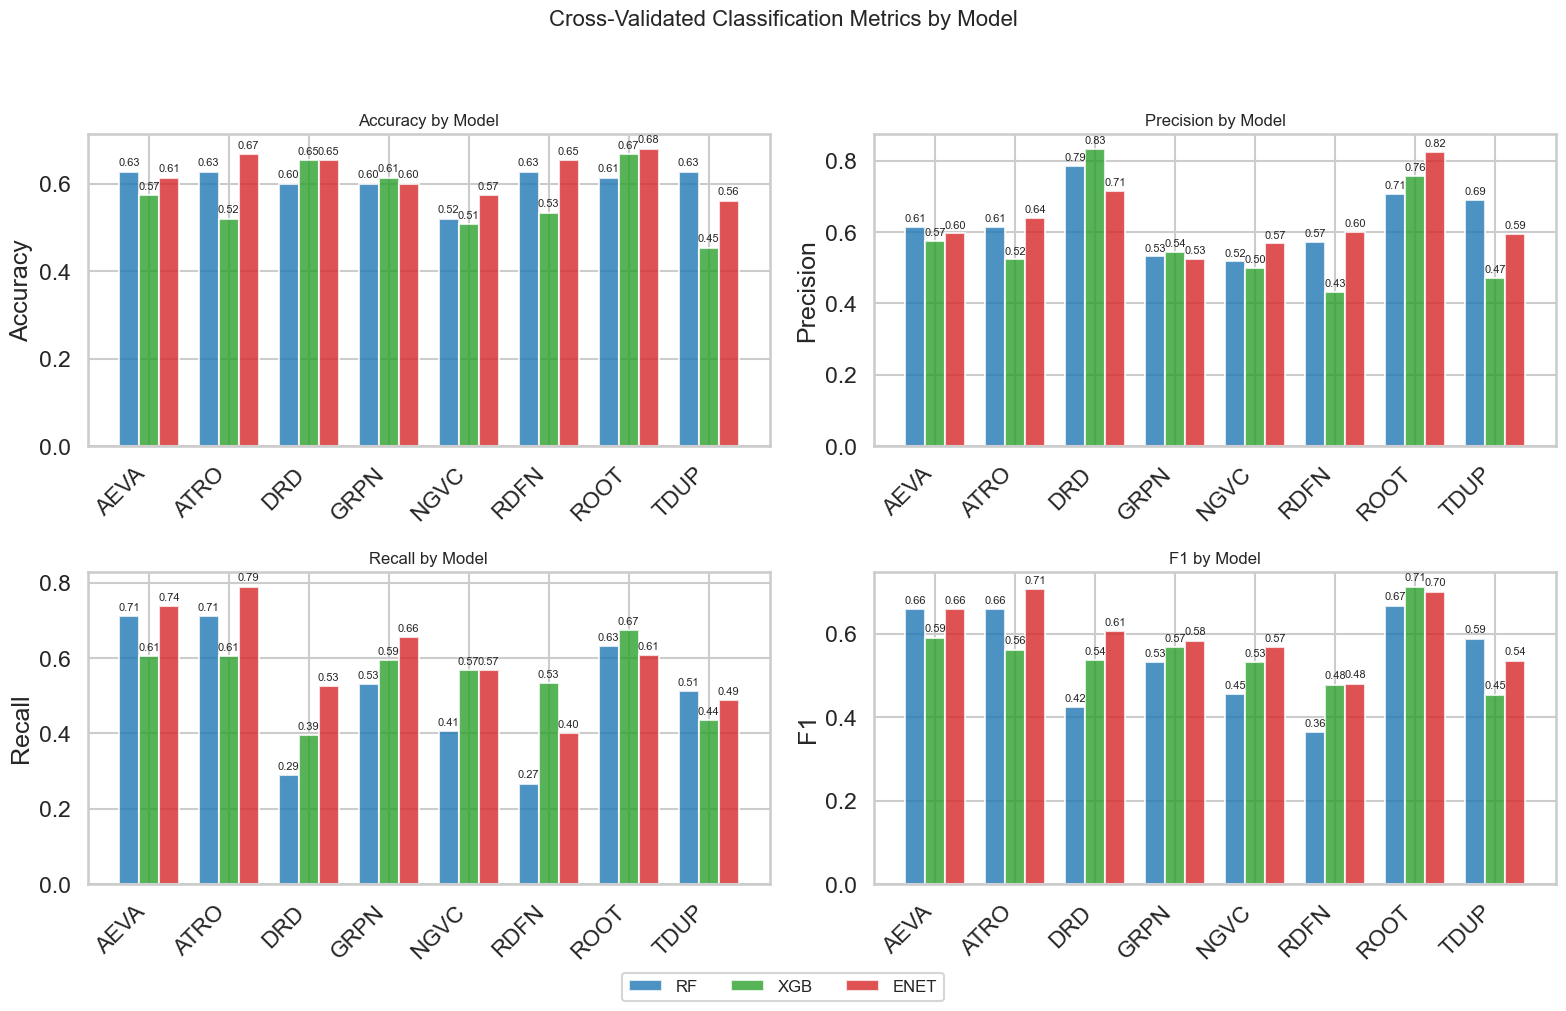

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing results_df
# results_df = pd.read_csv("your_results.csv")

# Plot setup
metrics = ["Accuracy", "Precision", "Recall", "F1"]
model_prefixes = ["RF", "XGB", "ENET"]
colors = {"RF": "tab:blue", "XGB": "tab:green", "ENET": "tab:red"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

x = range(len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bar_width = 0.25

    for i, model in enumerate(model_prefixes):
        offset = (i - 1) * bar_width  # shift bars left, center, right
        scores = results_df[f"{model}_{metric}"]
        bars = ax.bar(
            [xi + offset for xi in x],
            scores,
            width=bar_width,
            label=model,
            color=colors[model],
            alpha=0.8
        )

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    ax.set_title(f"{metric} by Model", fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["Ticker"], rotation=45, ha='right')

fig.suptitle("Cross-Validated Classification Metrics by Model", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(model_prefixes, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.02))
plt.savefig("model.png", dpi = 300)
plt.show()



In [148]:
full_cat

,Date,Ticker,Return,7D_Rolling_Mean,7D_Rolling_Variance,Volume,ticker_freq,sector_freq,Return_Lag1,Volume_Lag1,...,CPI,FED_RATE,GDP,IPI,PC1,PC2,PC3,Return_Binary,sector_sentiment_cat,market_sentiment_cat
0,2022-01-04,AEVA,-0.034641,NaN,NaN,-0.236455,0.0,0.241935,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,1.150988,-0.215267,1.524759,0,0,1
1,2022-01-04,ATRO,0.068327,NaN,NaN,-0.596350,0.0,0.016129,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,1.150988,-0.215267,1.524759,1,-1,1
2,2022-01-04,DRD,-0.007335,NaN,NaN,0.652325,0.0,0.096774,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,1.150988,-0.215267,1.524759,0,1,1
3,2022-01-04,GRPN,-0.015399,NaN,NaN,-0.682022,0.0,0.032258,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,1.150988,-0.215267,1.524759,0,1,1
4,2022-01-04,NGVC,0.023417,NaN,NaN,0.537677,0.0,0.000000,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,1.150988,-0.215267,1.524759,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.015736,0.002015,0.278188,0.0,0.112903,-0.006683,-0.300515,...,-1.461440,0.204018,1.580797,0.767781,-1.381344,1.405536,1.737336,1,1,1
6004,2024-12-30,NGVC,0.010384,0.005466,0.000347,-0.097638,0.0,0.000000,-0.025636,-0.056512,...,-1.461440,0.204018,1.580797,0.767781,-1.381344,1.405536,1.737336,1,0,1
6005,2024-12-30,RDFN,-0.032221,-0.001075,0.000798,0.322884,0.0,0.048387,-0.014528,-0.276840,...,-1.461440,0.204018,1.580797,0.767781,-1.381344,1.405536,1.737336,0,-1,1
6006,2024-12-30,ROOT,0.005328,0.003229,0.000772,-0.331713,0.0,0.435484,-0.041326,0.276707,...,-1.461440,0.204018,1.580797,0.767781,-1.381344,1.405536,1.737336,1,1,1


In [149]:
full_cat = full_cat.sort_values(by=['Ticker', 'Date'])

full_cat[["PC1", "PC2", "PC3"]] = full_cat.groupby('Ticker')[["PC1", "PC2", "PC3"]].shift(2)
full_cat[["ticker_freq", "sector_freq", "sector_sentiment_cat", "market_sentiment_cat"]] = full_cat.groupby('Ticker')[["ticker_freq", "sector_freq", "sector_sentiment_cat", "market_sentiment_cat"]].shift(2)
full_cat = full_cat.sort_values(by=['Date','Ticker'])

In [150]:
full_cat

,Date,Ticker,Return,7D_Rolling_Mean,7D_Rolling_Variance,Volume,ticker_freq,sector_freq,Return_Lag1,Volume_Lag1,...,CPI,FED_RATE,GDP,IPI,PC1,PC2,PC3,Return_Binary,sector_sentiment_cat,market_sentiment_cat
0,2022-01-04,AEVA,-0.034641,NaN,NaN,-0.236455,NaN,NaN,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,NaN,NaN,NaN,0,NaN,NaN
1,2022-01-04,ATRO,0.068327,NaN,NaN,-0.596350,NaN,NaN,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,NaN,NaN,NaN,1,NaN,NaN
2,2022-01-04,DRD,-0.007335,NaN,NaN,0.652325,NaN,NaN,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,NaN,NaN,NaN,0,NaN,NaN
3,2022-01-04,GRPN,-0.015399,NaN,NaN,-0.682022,NaN,NaN,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,NaN,NaN,NaN,0,NaN,NaN
4,2022-01-04,NGVC,0.023417,NaN,NaN,0.537677,NaN,NaN,NaN,NaN,...,-1.217332,-2.142895,-1.398718,-2.912992,NaN,NaN,NaN,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6003,2024-12-30,GRPN,0.012495,0.015736,0.002015,0.278188,0.0,0.145161,-0.006683,-0.300515,...,-1.461440,0.204018,1.580797,0.767781,-2.146762,0.904245,1.340293,1,1.0,1.0
6004,2024-12-30,NGVC,0.010384,0.005466,0.000347,-0.097638,0.0,0.000000,-0.025636,-0.056512,...,-1.461440,0.204018,1.580797,0.767781,-2.146762,0.904245,1.340293,1,0.0,1.0
6005,2024-12-30,RDFN,-0.032221,-0.001075,0.000798,0.322884,0.0,0.064516,-0.014528,-0.276840,...,-1.461440,0.204018,1.580797,0.767781,-2.146762,0.904245,1.340293,0,1.0,1.0
6006,2024-12-30,ROOT,0.005328,0.003229,0.000772,-0.331713,0.0,0.306452,-0.041326,0.276707,...,-1.461440,0.204018,1.580797,0.767781,-2.146762,0.904245,1.340293,1,1.0,1.0


In [151]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Scale macroeconomic variables
macro_cols = ['Epi', 'CPI', 'FED_RATE', 'GDP', 'IPI']
scaler_macro = StandardScaler()
full_cat[macro_cols] = scaler_macro.fit_transform(full_cat[macro_cols])

# Define models
models = {
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ENET": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                               max_iter=1000, random_state=42)
}

# Store results
results = []
target = 'Return_Binary'
tickers = full_cat['Ticker'].unique()

# Model evaluation loop
for ticker in tickers:
    subset = full_cat[full_cat['Ticker'] == ticker].dropna().sort_values('Date')
    X = subset.drop(columns=['Date', 'Ticker', 'Return', 'Return_Binary', 'Sector'], errors='ignore')
    y = subset[target]

    if len(X) < 100:
        continue

    # Time-based split: 70% train, 10% validation (ignore remaining 20%)
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]

    row = {"Ticker": ticker}

    for name, model in models.items():
        if name == "ENET":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            model.fit(X_train_scaled, y_train)
            y_val_pred = model.predict(X_val_scaled)
        else:
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)

        # Validation metrics
        row.update({
            f"{name}_Accuracy": accuracy_score(y_val, y_val_pred),
            f"{name}_Precision": precision_score(y_val, y_val_pred, zero_division=0),
            f"{name}_Recall": recall_score(y_val, y_val_pred, zero_division=0),
            f"{name}_F1": f1_score(y_val, y_val_pred, zero_division=0),
        })

    results.append(row)

# Compile and show results
results_df = pd.DataFrame(results)
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

  Ticker  RF_Accuracy  RF_Precision  RF_Recall     RF_F1  XGB_Accuracy  \
0   AEVA     0.600000      0.600000   0.631579  0.615385      0.626667   
1   ATRO     0.613333      0.600000   0.710526  0.650602      0.626667   
2    DRD     0.640000      0.720000   0.473684  0.571429      0.533333   
3   GRPN     0.466667      0.416667   0.625000  0.500000      0.600000   
4   NGVC     0.520000      0.512195   0.567568  0.538462      0.533333   
5   RDFN     0.613333      0.523810   0.366667  0.431373      0.560000   
6   ROOT     0.506667      0.655172   0.413043  0.506667      0.600000   
7   TDUP     0.666667      0.694444   0.641026  0.666667      0.586667   

   XGB_Precision  XGB_Recall    XGB_F1  ENET_Accuracy  ENET_Precision  \
0       0.625000    0.657895  0.641026       0.600000        0.595238   
1       0.625000    0.657895  0.641026       0.653333        0.630435   
2       0.551724    0.421053  0.477612       0.613333        0.655172   
3       0.521739    0.750000  0.615385   

/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


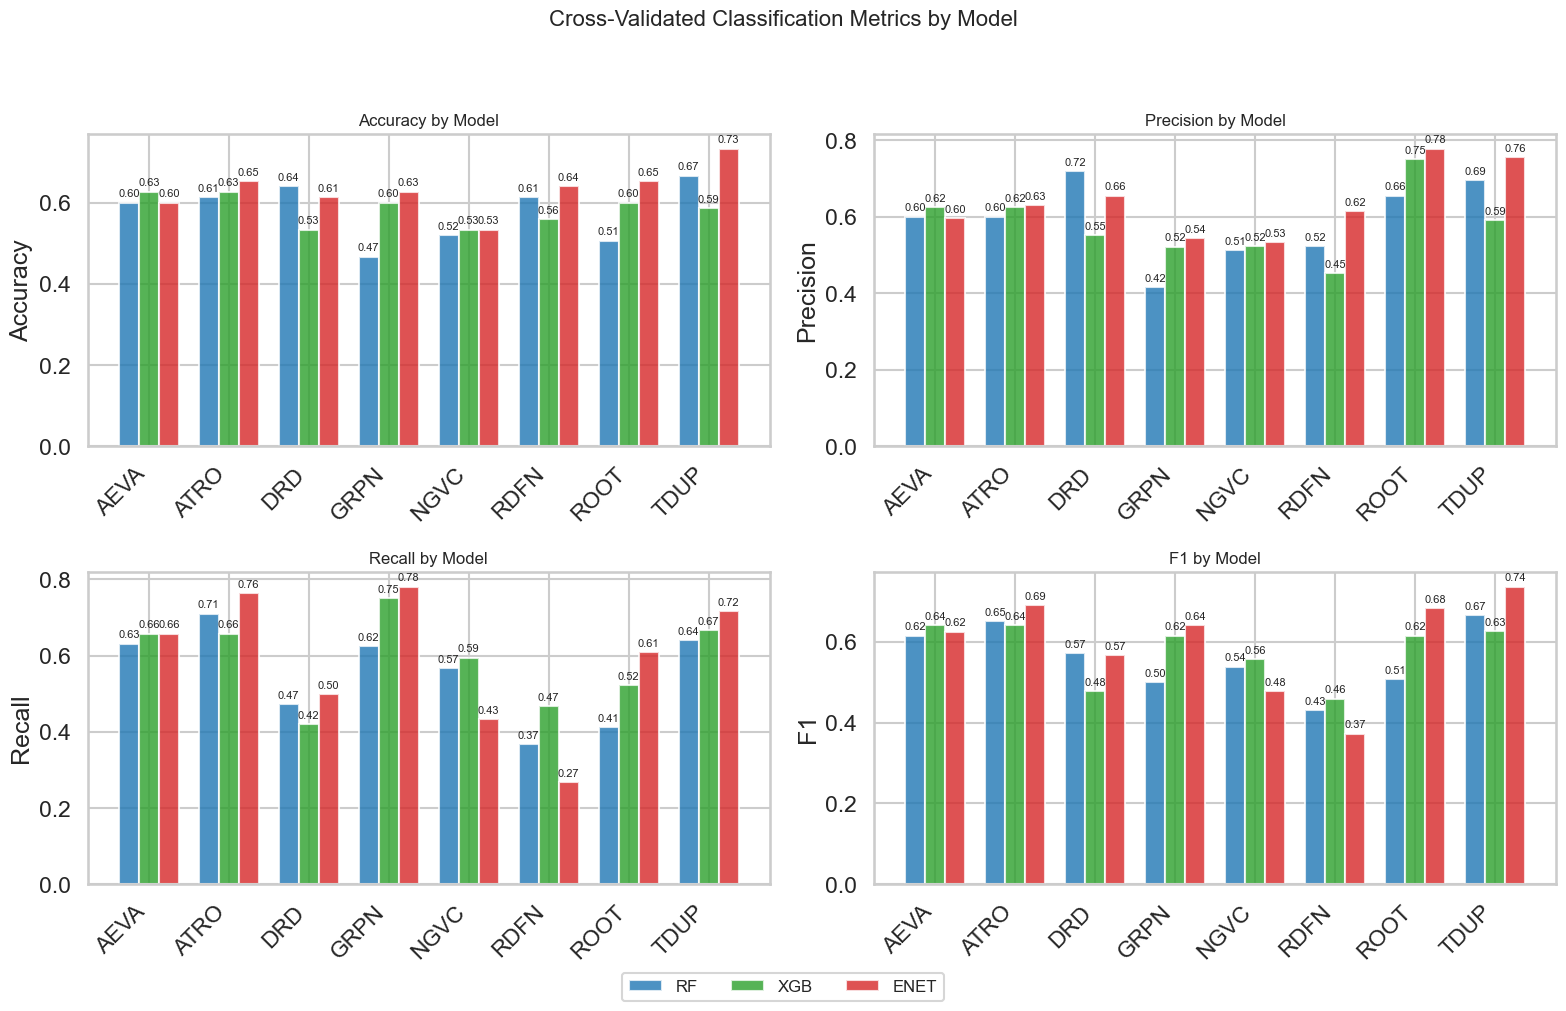

In [152]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = ["Accuracy", "Precision", "Recall", "F1"]
model_prefixes = ["RF", "XGB", "ENET"]
colors = {"RF": "tab:blue", "XGB": "tab:green", "ENET": "tab:red"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

x = range(len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bar_width = 0.25

    for i, model in enumerate(model_prefixes):
        offset = (i - 1) * bar_width  # shift bars left, center, right
        scores = results_df[f"{model}_{metric}"]
        bars = ax.bar(
            [xi + offset for xi in x],
            scores,
            width=bar_width,
            label=model,
            color=colors[model],
            alpha=0.8
        )

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    ax.set_title(f"{metric} by Model", fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["Ticker"], rotation=45, ha='right')

fig.suptitle("Cross-Validated Classification Metrics by Model", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(model_prefixes, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.02))
plt.savefig("model.png", dpi = 300)
plt.show()



In [153]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
df2 = full.copy()
Y = df2['Return']
drop_cols = ['Date', 'Ticker', 'Return', "sector_sentiment", "market_sentiment", "Return_Binary"]
X_return = df2.drop(columns=drop_cols)

feature_cols = X_return.columns.tolist()

# Drop missing values
df_model = pd.concat([X_return, Y], axis=1).dropna()
X = df_model[feature_cols]
Y = df_model['Return']

# Fit LassoCV
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, Y)

# Get non-zero coefficients
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Show important predictors
print(coef_df[coef_df['Coefficient'] != 0])

   Feature   Coefficient
2   Volume  5.498308e-03
12     PC1 -1.542437e-03
14     PC3 -1.385781e-03
13     PC2  8.780540e-04
10     GDP  4.896665e-07


In [154]:
columns = coef_df[coef_df['Coefficient'] != 0]["Feature"]
columns

2     Volume
12       PC1
14       PC3
13       PC2
10       GDP
Name: Feature, dtype: object

In [155]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Scale macroeconomic variables
macro_cols = ['Epi', 'CPI', 'FED_RATE', 'GDP', 'IPI']
scaler_macro = StandardScaler()
full_cat[macro_cols] = scaler_macro.fit_transform(full_cat[macro_cols])

# Define models
models = {
    "RF": RandomForestClassifier(random_state=42),
    "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "ENET": LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5,
                               max_iter=1000, random_state=42)
}

# Store results
results = []
target = 'Return_Binary'
tickers = full_cat['Ticker'].unique()

# Determine feature columns
exclude_cols = ['Date', 'Ticker', 'Return', 'Return_Binary', 'Sector']
columns = [col for col in full_cat.columns if col not in exclude_cols]

# Model evaluation loop
for ticker in tickers:
    subset = full_cat[full_cat['Ticker'] == ticker].dropna().sort_values('Date')

    X = subset[columns]
    y = subset[target]

    if len(X) < 100:
        continue

    # Time-based split: 70% train, 10% validation
    n = len(X)
    train_end = int(n * 0.7)
    val_end = int(n * 0.8)

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]

    row = {"Ticker": ticker}

    for name, model in models.items():
        if name == "ENET":
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)

            model.fit(X_train_scaled, y_train)
            val_pred = model.predict(X_val_scaled)
        else:
            model.fit(X_train, y_train)
            val_pred = model.predict(X_val)

        # Validation scores
        row.update({
            f"{name}_Accuracy": accuracy_score(y_val, val_pred),
            f"{name}_Precision": precision_score(y_val, val_pred, zero_division=0),
            f"{name}_Recall": recall_score(y_val, val_pred, zero_division=0),
            f"{name}_F1": f1_score(y_val, val_pred, zero_division=0),
        })

    results.append(row)

# Compile results
results_df = pd.DataFrame(results)
print(results_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

  Ticker  RF_Accuracy  RF_Precision  RF_Recall     RF_F1  XGB_Accuracy  \
0   AEVA     0.600000      0.600000   0.631579  0.615385      0.626667   
1   ATRO     0.613333      0.600000   0.710526  0.650602      0.626667   
2    DRD     0.640000      0.720000   0.473684  0.571429      0.533333   
3   GRPN     0.466667      0.416667   0.625000  0.500000      0.600000   
4   NGVC     0.520000      0.512195   0.567568  0.538462      0.533333   
5   RDFN     0.613333      0.523810   0.366667  0.431373      0.560000   
6   ROOT     0.506667      0.655172   0.413043  0.506667      0.600000   
7   TDUP     0.666667      0.694444   0.641026  0.666667      0.586667   

   XGB_Precision  XGB_Recall    XGB_F1  ENET_Accuracy  ENET_Precision  \
0       0.625000    0.657895  0.641026       0.600000        0.595238   
1       0.625000    0.657895  0.641026       0.653333        0.630435   
2       0.551724    0.421053  0.477612       0.613333        0.655172   
3       0.521739    0.750000  0.615385   

/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


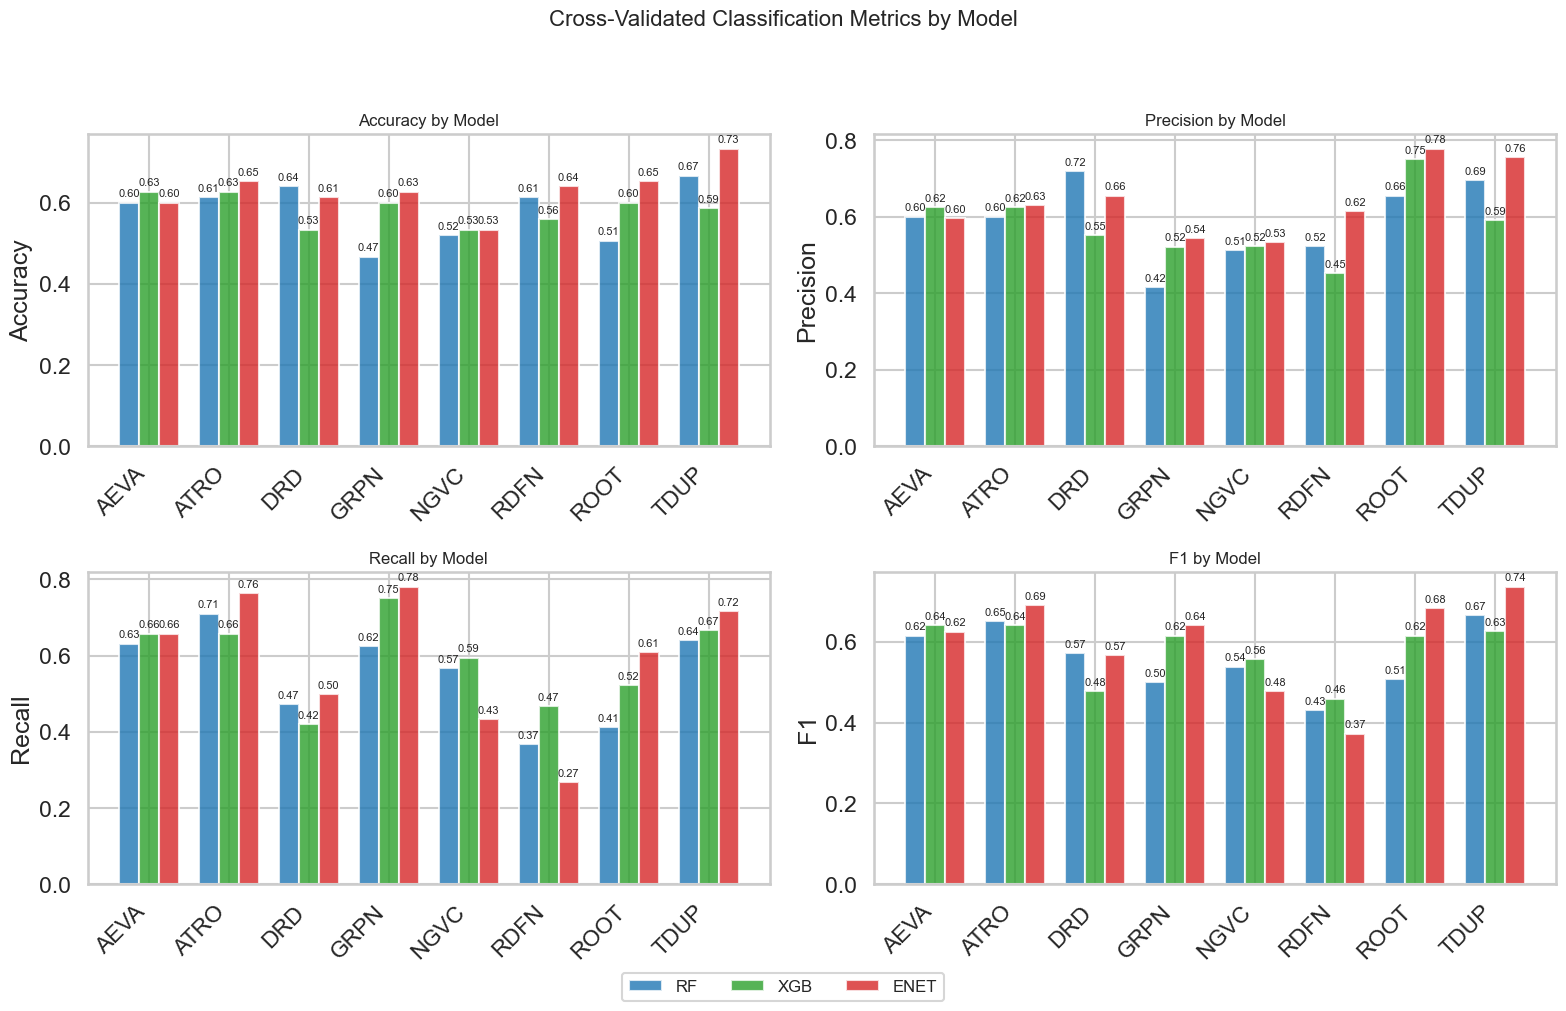

In [156]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = ["Accuracy", "Precision", "Recall", "F1"]
model_prefixes = ["RF", "XGB", "ENET"]
colors = {"RF": "tab:blue", "XGB": "tab:green", "ENET": "tab:red"}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

x = range(len(results_df))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bar_width = 0.25

    for i, model in enumerate(model_prefixes):
        offset = (i - 1) * bar_width  # shift bars left, center, right
        scores = results_df[f"{model}_{metric}"]
        bars = ax.bar(
            [xi + offset for xi in x],
            scores,
            width=bar_width,
            label=model,
            color=colors[model],
            alpha=0.8
        )

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.01,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=8
            )

    ax.set_title(f"{metric} by Model", fontsize=12)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df["Ticker"], rotation=45, ha='right')

fig.suptitle("Cross-Validated Classification Metrics by Model", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.legend(model_prefixes, loc='lower center', ncol=3, fontsize=12, bbox_to_anchor=(0.5, -0.02))
plt.savefig("model.png", dpi = 300)
plt.show()



In [159]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and normalize macro features
df = full_cat.copy()
macro_cols = ['Epi', 'CPI', 'FED_RATE', 'GDP', 'IPI']
scaler_macro = StandardScaler()
df[macro_cols] = scaler_macro.fit_transform(df[macro_cols])

# Best model per ticker (based on prior F1 evaluation)
best_models = {
    'AEVA': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'ATRO': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42),
    'DRD': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42),
    'GRPN': RandomForestClassifier(random_state=42),
    'NGVC': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42),
    'RDFN': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'ROOT': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42),
    'TDUP': LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
}

# Store predictions
final_predictions = []

for ticker, model in best_models.items():
    subdf = df[df['Ticker'] == ticker].dropna().sort_values('Date')

    if len(subdf) < 100:
        continue

    X = subdf.drop(columns=['Date', 'Ticker', 'Return', 'Return_Binary', 'Sector'], errors='ignore')
    y = subdf['Return_Binary']

    # Time-aware split: 80% train, 20% test
    n = len(X)
    split_idx = int(n * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Scale if using Elastic Net
    if isinstance(model, LogisticRegression):
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Train and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store predictions
    result = pd.DataFrame({
        'Ticker': ticker,
        'True_Label': y_test,
        'Predicted_Label': y_pred
    }, index=y_test.index)

    final_predictions.append(result)

# Combine all predictions
pred_df = pd.concat(final_predictions).reset_index(drop=True)

# Evaluate per ticker
metrics = []
for ticker in pred_df['Ticker'].unique():
    sub = pred_df[pred_df['Ticker'] == ticker]
    y_true = sub['True_Label']
    y_pred = sub['Predicted_Label']

    metrics.append({
        'Ticker': ticker,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0)
    })

# Display results
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


  Ticker  Accuracy  Precision    Recall        F1
0   AEVA  0.563758   0.527778  0.550725  0.539007
1   ATRO  0.624161   0.651515  0.565789  0.605634
2    DRD  0.624161   0.685185  0.486842  0.569231
3   GRPN  0.577181   0.677419  0.283784  0.400000
4   NGVC  0.496644   0.615385  0.285714  0.390244
5   RDFN  0.557047   0.612903  0.260274  0.365385
6   ROOT  0.597315   0.532609  0.742424  0.620253
7   TDUP  0.617450   0.565789  0.641791  0.601399


/Users/sophialin/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [09:21:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [166]:

returns_info = full_cat.loc[pred_df.index, ['Date', 'Return']].reset_index(drop=True)
simulation_df = pd.concat([pred_df.reset_index(drop=True), returns_info], axis=1)

simulation_df = simulation_df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

## Simulate $1,000 per ticker
tickers = simulation_df['Ticker'].unique()
initial_capital = 1000

model_results = {}
random_results = {}

np.random.seed(42)

for ticker in tickers:
    df_ticker = simulation_df[simulation_df['Ticker'] == ticker].reset_index(drop=True)

    # --- Model Strategy ---
    budget_model = initial_capital
    for _, row in df_ticker.iterrows():
        if row['Predicted_Label'] == 1:
            budget_model *= np.exp(row['Return'])
    model_results[ticker] = round(budget_model, 2)

    # --- Random Strategy ---
    budget_random = initial_capital
    random_decisions = np.random.randint(0, 2, size=len(df_ticker))
    for i, row in df_ticker.iterrows():
        if random_decisions[i] == 1:
            budget_random *= np.exp(row['Return'])
    random_results[ticker] = round(budget_random, 2)

# Step 5: Combine results into a DataFrame
results_df = pd.DataFrame({
    'Ticker': tickers,
    'Model_Final_Budget': [model_results[t] for t in tickers],
    'Random_Final_Budget': [random_results[t] for t in tickers]
})

print(results_df)


  Ticker  Model_Final_Budget  Random_Final_Budget
0   AEVA              457.93               311.74
1   ATRO              632.61               716.49
2    DRD              835.07              1065.86
3   GRPN             1277.26               648.25
4   NGVC             1062.97               251.06
5   RDFN              789.61               824.94
6   ROOT              479.38              1069.07
7   TDUP             3944.69              3217.55


In [167]:
# Total portfolio values
total_model = results_df['Model_Final_Budget'].sum()
total_random = results_df['Random_Final_Budget'].sum()

print(f"\n💼 Total ending budget (Model strategy): ${total_model:,.2f}")
print(f"🎲 Total ending budget (Random strategy): ${total_random:,.2f}")



💼 Total ending budget (Model strategy): $9,479.52
🎲 Total ending budget (Random strategy): $8,104.96
